# Transmissibility

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False
SAVE_DATA = True

First, setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

DATA = os.path.join(os.path.abspath(os.path.curdir), '{}.pkl.bz2')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_1


Then import all we need for the analysis

In [3]:
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import numpy as np
from pandas import DataFrame
import seaborn as sb

from gists.models import Sentence, Tree

from analysis.utils import grouper, memoized, mpl_palette

## 2 Transmissibility of sentences

First generate our data

In [4]:
trees = Tree.objects.experiment.all()
data = []
order = []
for tree in trees:
    root = tree.root
    root_length = len(root.content_words)
    order.append({'tree id': tree.id,
                  'root length': root_length})
    for sentence in tree.sentences.kept.all():
        length = len(sentence.content_words)
        for child in sentence.children.kept.all():
            data.append({'tree id': tree.id,
                         'sentence id': sentence.id,
                         'length': length,
                         'root length': root_length,
                         'depth': sentence.depth,
                         'branch id': child.head.id,
                         'transmit success': sentence.oc_distance(child) == 0})
data = DataFrame(data)
data_m15 = data[data['root length'] < 15]
root_order = DataFrame(order).sort_values(['root length', 'tree id'])

In [5]:
if SAVE_DATA:
    data.to_pickle(DATA.format('transmissibility'))

### 2.1 Quick look at interactions

First with all the data

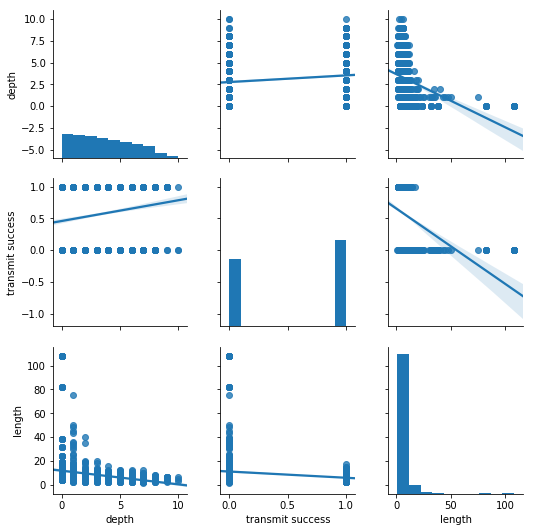

In [6]:
g = sb.pairplot(data=data,
                vars=['depth', 'transmit success', 'length'], kind='reg')
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/depth_transmissibility_length_interactions.png', dpi=300)

Then restricting to trees where the root sentence is less than 15 content words

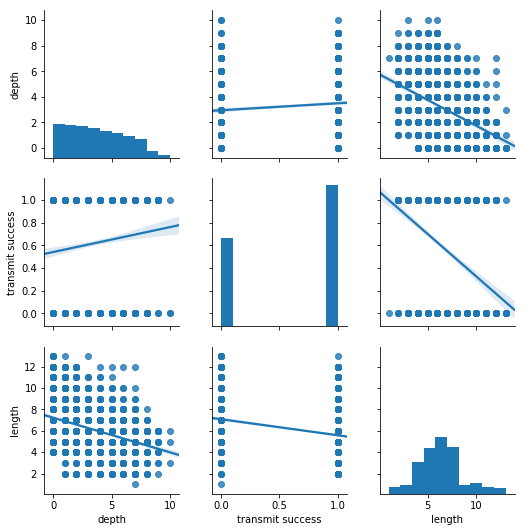

In [7]:
g = sb.pairplot(data=data_m15,
                vars=['depth', 'transmit success', 'length'], kind='reg')
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/depth_transmissibility_length_interactions_m15.png',
              dpi=300)

### 2.2 Transmissibility ~ depth, global

Plotting function to have the evolution of average transmissibility

In [8]:
def plot_transmissibility(data, **kwargs):
    color = kwargs.get('color', sb.color_palette()[0])
    depth_success = data.groupby('depth')['transmit success']

    # Compute transmissibilities per depth
    heights = depth_success.mean()
    cis = depth_success.std() * 1.96 / np.sqrt(depth_success.size() - 1)

    # Plot
    ax = plt.gca()
    ax.plot(heights.index, heights, color=color)
    ax.fill_between(heights.index, heights - cis, heights + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)
    ax.set_ylim(0, 1)
    ax.set_xlabel('depth')
    ax.set_ylabel('transmit success')

Evolution of global transmissibility with all the data, computed as average per depth and as logistic regression against depth

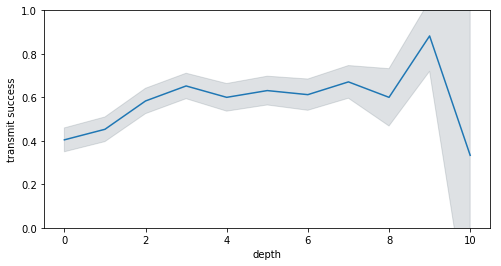

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_transmissibility(data)
if SAVE_FIGURES:
    fig.savefig('/home/sl/Downloads/gistr/transmissibility-global_average.png', dpi=300)

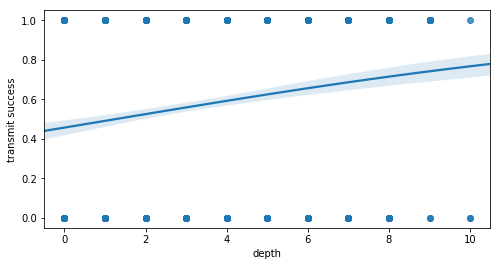

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
sb.regplot('depth', 'transmit success', data=data, logistic=True, ax=ax)
if SAVE_FIGURES:
    fig.savefig('/home/sl/Downloads/gistr/transmissibility-global_logistic.png', dpi=300)

Then restricting to trees where the root sentence is less than 15 content words

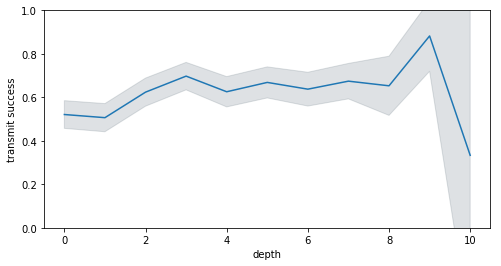

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_transmissibility(data_m15)
if SAVE_FIGURES:
    fig.savefig('/home/sl/Downloads/gistr/transmissibility-global_average_m15.png',
                dpi=300)

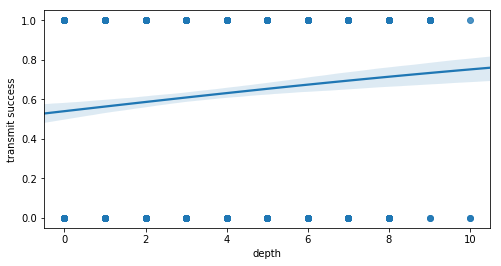

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
sb.regplot('depth', 'transmit success', data=data_m15, logistic=True, ax=ax)
if SAVE_FIGURES:
    fig.savefig('/home/sl/Downloads/gistr/transmissibility-global_logistic_m15.png',
                dpi=300)

### 2.3 Transmissibility ~ depth, per number of content words

First with all the data, as average per depth and as logistic regression

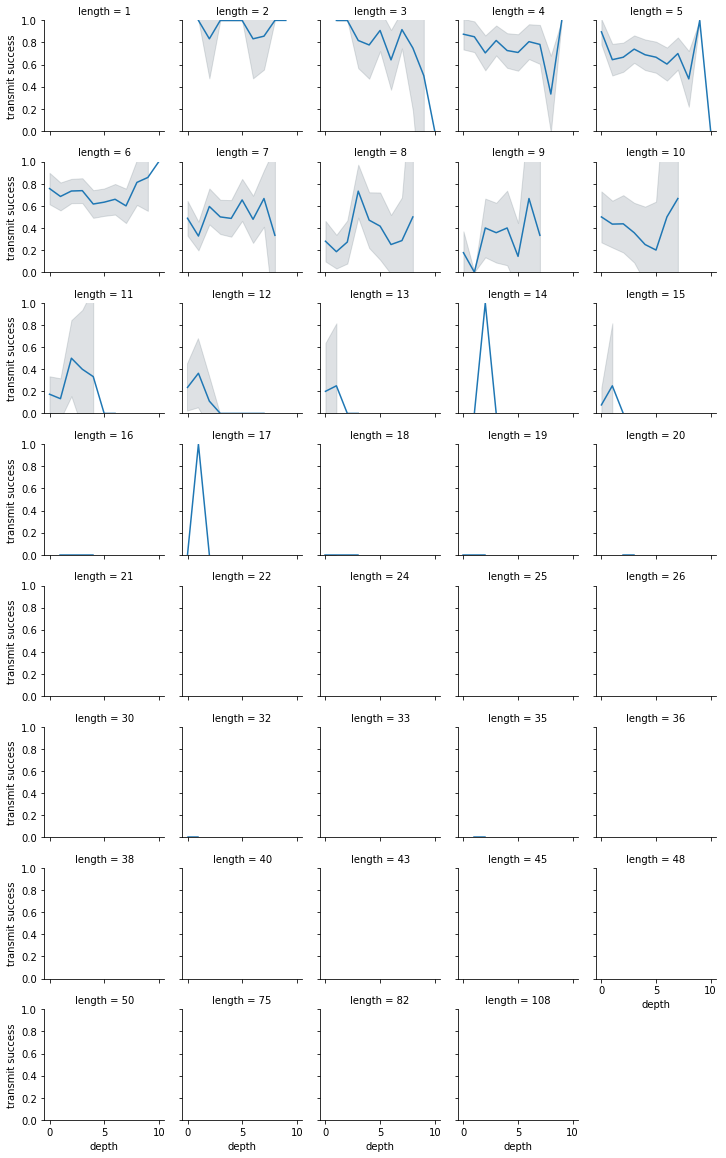

In [13]:
ordered_lengths = sorted(set(data.length.values))
g = sb.FacetGrid(data=data, col='length', col_wrap=5,
                 sharex=True, sharey=True, size=2,
                 col_order=ordered_lengths)
g.map_dataframe(plot_transmissibility)
g.set_xlabels('depth')
g.set_ylabels('transmit success')
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/transmissibility-length_average.png', dpi=300)

Then restricting to trees where the root sentence is less than 15 content words

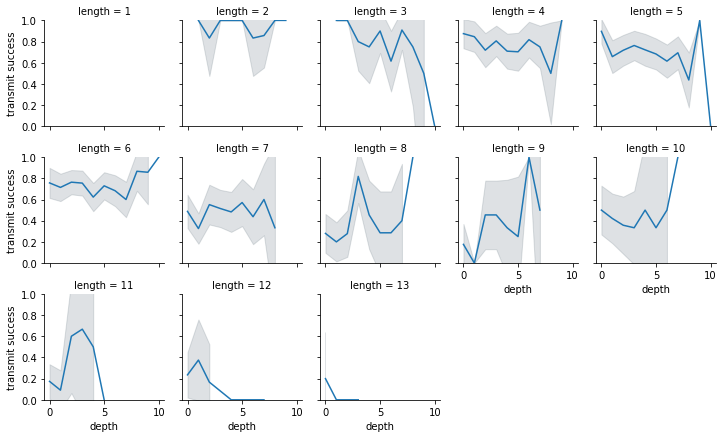

In [14]:
ordered_lengths_m15 = sorted(set(data_m15.length.values))
g = sb.FacetGrid(data=data_m15, col='length', col_wrap=5,
                 sharex=True, sharey=True, size=2,
                 col_order=ordered_lengths_m15)
g.map_dataframe(plot_transmissibility)
g.set_xlabels('depth')
g.set_ylabels('transmit success')
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/transmissibility-length_average_m15.png', dpi=300)

### 2.4 Transmissibility ~ depth, per tree

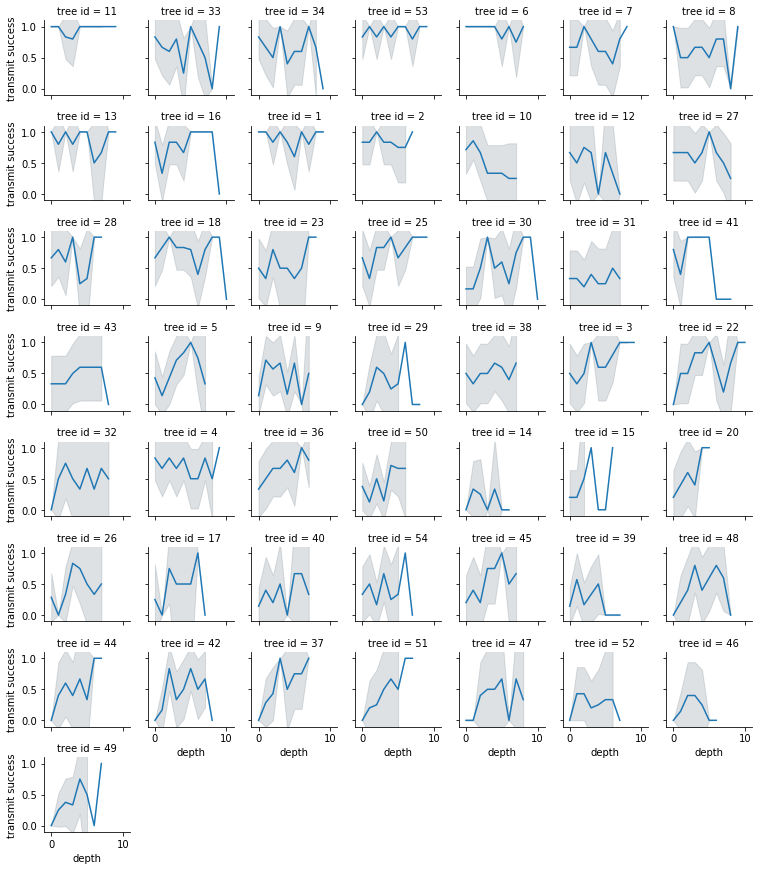

In [15]:
g = sb.FacetGrid(data=data, col='tree id', col_wrap=7,
                 sharex=True, sharey=True, size=1.5,
                 col_order=root_order['tree id'])
g.map_dataframe(plot_transmissibility)
g.set_xlabels('depth')
g.set_ylabels('transmit success')
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/transmissibility-tree_average.png', dpi=300)